## Model Training

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor

import warnings

#### Import the CSV Data as Pandas DataFrame

In [142]:
df = pd.read_csv('data/stud_final.csv')

#### Show Top 5 Records

In [143]:
df = df.dropna(axis=1, how='all')  # Drop columns where all values are NaN
df.head()

,ID No,Prog Code,Gender,YoG,CGPA,CGPA100,CGPA200,CGPA300,CGPA400,SGPA
0,42308,ICE,Female,2010,3.23,2.88,3.48,2.62,2.90,3.13
1,70978,BCH,Female,2010,3.58,3.25,4.26,3.37,3.47,3.02
2,31602,BCH,Male,2010,2.21,1.78,1.98,1.49,2.51,2.19
3,63847,BCH,Male,2010,2.70,2.67,2.44,2.00,2.35,3.19
4,30158,BCH,Female,2010,3.88,3.61,3.69,3.63,4.58,4.24


#### Preparing X and Y variables

In [144]:
X = df.drop(columns=['CGPA'],axis=1)

In [145]:
X.head()

,ID No,Prog Code,Gender,YoG,CGPA100,CGPA200,CGPA300,CGPA400,SGPA
0,42308,ICE,Female,2010,2.88,3.48,2.62,2.90,3.13
1,70978,BCH,Female,2010,3.25,4.26,3.37,3.47,3.02
2,31602,BCH,Male,2010,1.78,1.98,1.49,2.51,2.19
3,63847,BCH,Male,2010,2.67,2.44,2.00,2.35,3.19
4,30158,BCH,Female,2010,3.61,3.69,3.63,4.58,4.24


In [146]:
print("Categories in 'Program Code' variable:     ",end=" " )
print(df['Prog Code'].unique())

print("Categories in 'Gender' variable:  ",end=" ")
print(df['Gender'].unique())

print("Categories in'Year Of Graduation' variable:",end=" " )
print(df['YoG'].unique())



Categories in 'Program Code' variable:      ['ICE' 'BCH' 'MCB' 'BLD' 'CHE' 'CHM' 'CVE' 'CIS' 'MIS' 'CEN' 'EEE' 'MAT'
 'MCE' 'PET' 'PHYE' 'PHYR' 'PHYG']
Categories in 'Gender' variable:   ['Female' 'Male']
Categories in'Year Of Graduation' variable: [2010 2011 2012 2013 2014]


In [147]:
y = df['CGPA']

In [148]:
y

0       3.23
1       3.58
2       2.21
3       2.70
4       3.88
        ... 
3041    4.18
3042    2.91
3043    3.66
3044    4.56
3045    4.18
Name: CGPA, Length: 3046, dtype: float64

In [149]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [150]:
X = preprocessor.fit_transform(X)

In [151]:
X.shape

(3046, 26)

In [152]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((2436, 26), (610, 26))

In [153]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split


df = pd.read_csv('data/stud_final.csv')
df = df.dropna(axis=1, how='all') 
# Save the target column separately
target = df['CGPA']

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df.drop(columns=['CGPA']), drop_first=True)

# Reattach the target column
df_encoded['CGPA'] = target

# Define target and features
X = df_encoded.drop(columns='CGPA')
y = df_encoded['CGPA']



# 3. **ANOVA F-Value (For Numerical and Categorical Features in Classification)**
# Use ANOVA F-value for classification tasks
anova_selector = SelectKBest(f_classif, k=min(7, X.shape[1]))
X_new_anova = anova_selector.fit_transform(X, y)

# Show the selected features based on ANOVA F-Value
selected_features_anova = X.columns[anova_selector.get_support()]
print("\nSelected features based on ANOVA F-Value:", selected_features_anova)



Selected features based on ANOVA F-Value: Index(['CGPA100', 'CGPA200', 'CGPA300', 'CGPA400', 'SGPA', 'Prog Code_MIS',
       'Gender_Male'],
      dtype='object')


#### Create an Evaluate Function to give all metrics after model Training

In [154]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [163]:
models = {
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "ElasticNet Regression": ElasticNet(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "MLP Regressor": MLPRegressor(),
 
    
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0884
- Mean Absolute Error: 0.0591
- R2 Score: 0.9834
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0816
- Mean Absolute Error: 0.0581
- R2 Score: 0.9868


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1178
- Mean Absolute Error: 0.0916
- R2 Score: 0.9705
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1386
- Mean Absolute Error: 0.1091
- R2 Score: 0.9620


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1573
- Mean Absolute Error: 0.1143
- R2 Score: 0.9510


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.0371
- Mean Absolute Error: 0.0263
- R2 Score: 0.9971
---------

### Results

In [164]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Ridge,0.986838
3,Random Forest Regressor,0.981835
6,MLP Regressor,0.975405
1,K-Neighbors Regressor,0.961961
5,AdaBoost Regressor,0.960168
2,Decision Tree,0.951016
4,ElasticNet Regression,0.265727


## Ridge Regression

In [157]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Initialize the Ridge Regression model
ridge_model = Ridge(fit_intercept=True)

# Fit the model on the training data
ridge_model = ridge_model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred_ridge = ridge_model.predict(X_test)

# Calculate the R^2 score (coefficient of determination)
ridge_score = r2_score(y_test, y_pred_ridge) * 100

# Print the accuracy of the model
print("Accuracy of the Ridge model is %.2f" % ridge_score)


Accuracy of the Ridge model is 98.68


## Plot y_pred and y_test

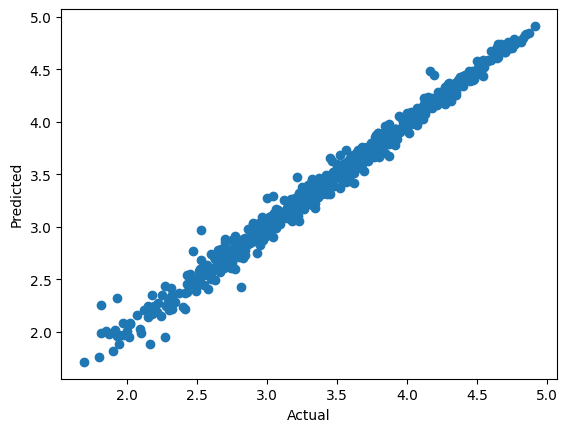

In [158]:
plt.scatter(y_test,y_pred_ridge);
plt.xlabel('Actual');
plt.ylabel('Predicted');

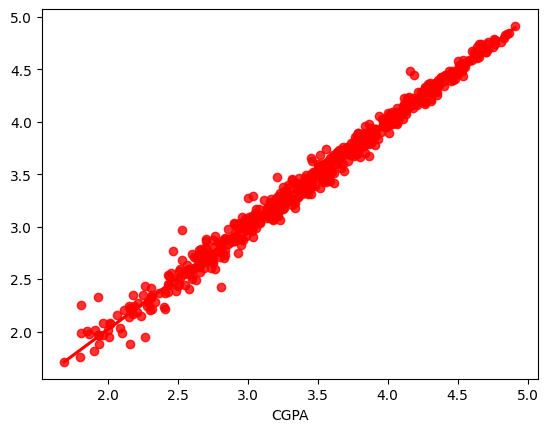

In [159]:
sns.regplot(x=y_test,y=y_pred_ridge,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [160]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_ridge,'Difference':y_test-y_pred_ridge})
pred_df

,Actual Value,Predicted Value,Difference
1018,4.40,4.394158,0.005842
642,4.44,4.446257,-0.006257
2241,3.45,3.314633,0.135367
1377,3.52,3.526251,-0.006251
2221,2.31,2.332493,-0.022493
...,...,...,...
2730,3.37,3.465654,-0.095654
2404,3.76,3.669722,0.090278
498,4.38,4.424870,-0.044870
2936,3.55,3.494343,0.055657
